# OBTENCION DE DATOS
**IMPORTAR LIBRERIAS Y OBTENER EL DATASET**

En primer lugar, importaremos las siguientes librerias necesarias para el analisis y procederemos a leer y mostrar el dataset.

In [3]:
import re
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.0f}'.format
warnings.filterwarnings('ignore')

In [4]:
url ='https://raw.githubusercontent.com/simonzanetti/2023.2-SysArmy-IT-Salaries-Survey/main/cleaned_dataset.csv'
df = pd.read_csv(url)

#display(df.head(1))
#print("Shape: " + str(df.shape))

HTTPError: HTTP Error 404: Not Found

# PREPROCESAMIENTO
**ORDENAR COLUMNAS**

El primer paso de nuestra limpieza sera traducir al ingles el nombre de las columnas y eliminar aquellas que no sean relevantes para el analisis. Tambien ordene las columnas en las categorias:
- Empleado
- Trabajo
- Empresa
- Sueldo
- Herramientas
- Estudios

Las columnas eliminadas fueron:
- 'work_country': La totalidad de los encuestados es de Argentina
- 'ARS/USD_exchange': No solo que el porcentaje de los que cobra parte o la totalidad de su sueldo en dolares es pequeño, sino tambien que existen varios tipos de cotizacion y no se aclara cual se usa en cada caso, ademas que la cotizacion suele variar segun las semanas, horas o dias, por lo que es una variable inestable y he decidido eliminarla.
- 'is:number': Una variable que no vamos a utilizar.

In [60]:
columns_names = ['work_country','work_province','work_type','work_contract_type',
                'last_month_gross_salary','last_month_net_salary','salary_in_usd',
                'ARS/USD_exchange','salary_has_bonus','salary_bonus_tied_to',
                '2023_salary_adjusment_times','percentage_adjustment',
                'last_adjustment_month','last_semester_salary_comparison',
                'work_place_benefits','salary_satisfaction','work_title','years_experience',
                'years_in_company','years_in_position','people_in_charge','platforms',
                'programming_languages','frameworks','databases','qa_testing_tools',
                'company_size','work_mode','office_days_number(hybrid)','work_place_satisfaction',
                'AI_tools_use','finish_survey(1)','highest_level_studies','status','degree/specialization',
                'university/school','finish_survey(2)','work_on-call_duty','salary_on-call_duty',
                'is_number','finish_survey(3)','age','gender']

for i, nuevo_nombre in enumerate(columns_names):
    df.rename(columns={df.columns[i]: nuevo_nombre}, inplace=True)

salaries = pd.concat([df.iloc[:,0:2],df.iloc[:,41:],df.iloc[:,16],
                      df.iloc[:,2:4],df.iloc[:,27],df.iloc[:,17:21],df.iloc[:,26:27],df.iloc[:,28:30],df.iloc[:,14],
                      df.iloc[:,4:14],df.iloc[:,15],df.iloc[:,21:26],df.iloc[:,30:41]],
                      axis=1)

salaries.drop(inplace=True, columns=[
                                    'work_country','ARS/USD_exchange','2023_salary_adjusment_times',
                                    'percentage_adjustment','last_adjustment_month',
                                    'last_semester_salary_comparison','finish_survey(1)','finish_survey(2)',
                                    'work_on-call_duty','salary_on-call_duty','is_number','finish_survey(3)'
                                    ])

print(salaries.dtypes)

work_province                  object
age                             int64
gender                         object
work_title                     object
work_type                      object
work_contract_type             object
work_mode                      object
years_experience              float64
years_in_company              float64
years_in_position             float64
people_in_charge                int64
company_size                   object
office_days_number(hybrid)      int64
work_place_satisfaction         int64
work_place_benefits            object
last_month_gross_salary       float64
last_month_net_salary         float64
salary_in_usd                  object
salary_has_bonus               object
salary_bonus_tied_to           object
salary_satisfaction             int64
platforms                      object
programming_languages          object
frameworks                     object
databases                      object
qa_testing_tools               object
AI_tools_use

**LIMPIEZA Y TRANSFORMACION DE NANS**

In [4]:
#print('Cantidad de Nans por limpiar: ')
#print(salaries.isna().sum()[salaries.isna().sum() > 0])

#SALARY_IN_USD
#print(salaries['salary_in_usd'].unique())
salaries['salary_in_usd'].fillna('No cobro mi salario en dolares',inplace=True)

#TOOLS
salaries.loc[:, 'platforms':'AI_tools_use'] = salaries.loc[:, 'platforms':'AI_tools_use'].fillna('Ninguna de las anteriores')

#STUDIES
#print(df['finish_survey(1)'].unique())
#print(df['highest_level_studies'].unique())
for columns in ('highest_level_studies','status','degree/specialization','university/school'):
    salaries.loc[(df['finish_survey(1)'] == 'Terminar encuesta') |
                 (df['finish_survey(1)'] == 'Responder sobre guardias'), columns] = 'Prefiero no responder'

for columns in ('degree/specialization','university/school'):
    salaries.loc[(df['highest_level_studies'] == 'Secundario'), columns] = 'Prefiero no responder'

**LIMPIEZA DE DUPLICADOS**


**NORMALIZACION DE VALORES**

En algunas columnas de este dataset nos encontraremos con una gran dispersion de opciones, con valores incorrectos o con valores que no representan de forma adecuada la respuesta del encuestado. Debido a ello necesitamos realizar una normalizacion de valores, en algunos casos en formato string y en otros casos en formato numerico.

Con la necesidad de reducir el tamaño del codigo, he creado una funcion que toma un dataset, una columna y un diccionario que contiene un mapeo regex, devolviendo un nuevo dataset normalizado.

Mediante el metodo pd.nunique() podemos ver la cantidad de opciones por cada variable, notando ciertas irregularidades:
- **'gender'**: Presenta 144 opciones diferentes de generos, lo cual nos muestra que exste una dispersion erronea en los datos.
- **'work title'**: Presenta una gran dispersion de valores.
- **'people_in_charge'**: Hay 58 opciones que varian entre 0 y 300. Lo ideal seria agruparlas en categorias mas generales, pero para ello se necesita realizar un analisis para visualizar outliers y correlacion con otras variables para detectar valores falsos.  
- **'company_size'**: Hay 11 categorias que varian entre 0 y 10000. Lo ideal seria agruparlas en categorias mas generales, pero para ello se necesita realizar un analisis para visualizar outliers y correlacion con otras variables para detectar valores falsos.
- **'office_days_number(hybrid)'**: Las opciones '0' y '5' no son correctas, ya que representan a los empleados que o no van nunca a la oficina o que van todos los dias, lo cual no condice con el modo de trabajo hibrido. Se necesita un analisis previo antes de normalizar.



**FUNCIONES AUXILIARES NORMALIZACION**

In [5]:
def normalize_dataframe(df_in, column_name, regex_assign_map):
    df_out = df_in.copy()
    for regex, value in regex_assign_map.items():
        print("\nElementos de " + str.capitalize(column_name) + " que integran la categoria " + regex +':')
        compiled_regex = re.compile(regex, re.I)
        mask = df_in[column_name].str.strip().str.match(compiled_regex, na=False)
        print(df_in[df_out[column_name].str.strip().str.match(compiled_regex, na=False)][column_name].unique())
        df_out.loc[mask, column_name] = value
    return df_out

def extract_values(column):
    value_counts_series = (column.str.extractall(r"(?P<count>[^,]+),? ?")["count"].value_counts(sort=True))
    df_out = pd.DataFrame({'item': value_counts_series.index, 'counts': value_counts_series.values})
    return df_out

In [186]:
#print("Cantidad de valores que toma cada variable: ")
#print(salaries.nunique())

**WORKER**

In [ ]:
#GENERO
#print(salaries['gender'].unique())

salaries_temp = normalize_dataframe(salaries, 'gender',
    {
        "^(?!.*(mujer)).*hombre.*|.*macho.*|.*muchacho.*|.*varoo.*|.*masculino.*|^(?!.*(?:trans|bi|\b(var[oó]n cis)\b))var[oó]n" : "Varón Cis",
        "^(?!.*(?:trans|bi|ag[eé]nero|var[oó]n|hombre|hombres)).*mujer|.*mujer de cuando solo existian hombres y mujeres*." : "Mujer Cis",
        "^(?=.*mujer|var[oó]n)(?=.*trans)(?!.*nb).*" : "Otros",
        "^(?=.*mujer|var[oó]n)\b(bi)\b" : "Otros",
        ".*ag[eé]nero.*" : "Otros",
        ".*nb.*|.*no binario.*|.*no binarie.*|big[eé]nero|.*varon bi.*" : "Otros",
        ".*fluido.*" : "Otros",
        ".*queer.*" : "Otros",
        ".*puto.*|.*marika.*|.*lesbiana.*" : "Otros",
    })
    
print('\nElementos de Gender que no entran en las categorias anteriores')
print(salaries_temp['gender'][~salaries_temp['gender'].isin(['Varón Cis','Mujer Cis','Prefiero no decir','Otros'])].unique())
salaries_temp['gender'] = np.where(salaries_temp['gender'].isin(['Varón Cis','Mujer Cis','Prefiero no decir','Otros']), salaries_temp['gender'], 'No especificados o erroneos')

**WORK**


Elementos de Work_title que integran la categoria bi|data analyst:
['BI Analyst / Data Analyst' 'Data analyst' 'BI Trainee' 'BI leader'
 'BI/Data Analist/Data Science' 'BI consultant']

Elementos de Work_title que integran la categoria manager:
['Manager / Director' 'Manager/Scrum Master/Web developer']

Elementos de Work_title que integran la categoria analista:
['Analista de soporte técnico' 'Analista funcional soporte transaccional'
 'Analista de accesos' 'Analista funcional' 'Analista Sr'
 'Analista de seguridad - SOC' 'Analista de Ciberseguridad'
 'analista funcional' 'Analista de Integraciones' 'Analista i+d'
 'Analista de control IT / SysAdmin' 'analista de sistemas'
 'Analista de soporte on site' 'Analista SOC' 'Analista de Service Desk'
 'Analista de Sistemas' 'Analista IAM' 'Analista Funcional'
 'Analista tecnico' 'Analista de Hardware' 'Analista de sistemas'
 'Analista' 'Analista funcional, de todo un poco. ' 'Analista Tecnico'
 'Analista funcional y documentador' 'Analista

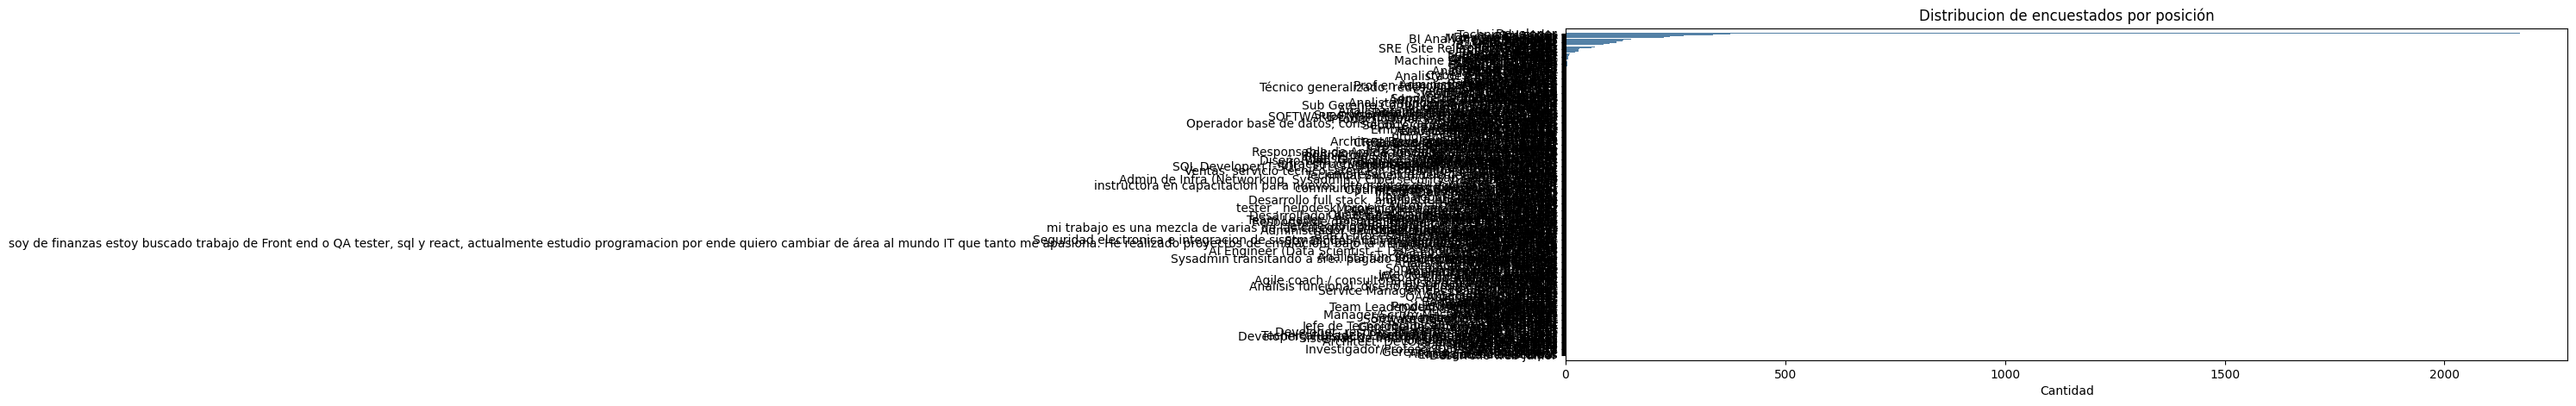

In [47]:
#WORK_TITLE
#print(salaries['work_title'].unique())

salaries1 = normalize_dataframe(salaries, 'work_title',
    {
        "bi|data analyst" : "BI Analyst / Data Analyst",
        "manager" : "BI Analyst / Data Analyst",
        "analista" : "BI Analyst / Data Analyst",
    })

fig = plt.figure(figsize=(15, 5))
ax = sns.countplot(y=salaries['work_title'], color='steelblue', order=df["work_title"].value_counts().index)
plt.title("Distribucion de encuestados por posición",loc='center')
plt.xlabel("Cantidad")
plt.ylabel('')
#ax.bar_label(ax.containers[0], padding=3)
ax.margins(y=0.015)

In [27]:
# WORK_CONTRACT TYPE
#print(salaries["work_contract_type"].unique())
salaries_temp['work_contract_type'] = salaries['work_contract_type'].replace({
                                                                                'Staff (planta permanente)' : 'Planta permanente',
                                                                                'Tercerizado (trabajo a través de consultora o agencia)' : 'Tercerizado',
                                                                                'Contractor' : 'Contratista',
                                                                                'Participación societaria en una cooperativa': 'Participación societaria'
                                                                            })

In [53]:
# WORK_MODE
#print(salaries["work_mode"].unique())
salaries_temp['work_mode'] = salaries['work_mode'].replace({
                                                            '100% presencial' : 'Presencial',
                                                            'Híbrido (presencial y remoto)' : 'Híbrido',
                                                            '100% remoto' : 'Remoto'
                                                          })


**COMPANY**

In [ ]:
#PEOPLE_IN_CHARGE
'''
ESPERAR ANALISIS
print(sorted(salaries['people_in_charge'].unique()))
sns.countplot(x=salaries['people_in_charge'], color='steelblue')
sns.scatterplot(data=salaries,x='people_in_charge',y = 'years_experience')
'''

In [ ]:
#COMPANY_SIZE
'''
ESPERAR ANALISIS
salaries['company_size'] = salaries['company_size'].str.replace(r'\bDe\b|\bpersonas\b', '', regex=True).str.strip()
salaries['company_size'].replace({'1 (solamente yo)' : '1','11  a 50' : '11 a 50'})
print(sorted(salaries['company_size'].unique()))
sns.countplot(y=salaries['company_size'], color='steelblue',order=salaries['company_size'].value_counts().index)
sns.scatterplot(data=salaries,x='people_in_charge',y = 'years_experience')
'''

In [ ]:
#OFFICE_DAYS_NUMBER
'''
ESPERAR ANALISIS
print(sorted(salaries['office_days_number(hybrid)'].unique()))
#sns.countplot(y=salaries['office_days_number(hybrid)'], color='steelblue',order=salaries['office_days_number(hybrid)'].value_counts().index)
sns.heatmap(pd.crosstab(salaries['office_days_number(hybrid)'], salaries['work_mode']), annot=True, fmt='d', cmap='YlGnBu')
'''

In [ ]:
#WORK_PLACE_SATISFACTION
'''
ES NECESARIO ALGUN TIPO DE CLUSTERING PARA AGRUPAR
#WORK_PLACE_SATISFACTION
#print('work_place_satisfaction'].unique())
salaries['work_place_satisfaction'] = salaries['work_place_satisfaction'].replace({
                                                            1:'Muy insatisfecho',2:'Muy insatisfecho',
                                                            3:'Escasamente satisfecho',4:'Escasamente satisfecho',5: 'Escasamente satisfecho',
                                                            6:'Ampliamente satisfecho',7:'Ampliamente satisfecho',8: 'Ampliamente satisfecho',
                                                            9:'Muy satisfecho',10:'Muy satisfecho'
                                                            })
'''

In [63]:
#WORK_BENEFITS
#print(salaries['work_place_benefits'].unique())
benefits_count = extract_values(salaries['work_place_benefits'])

**SALARY**

In [28]:
#SALARY_SATISFACTION
#print(salaries['salary_satisfaction'].unique())
salaries_temp['salary_satisfaction'] = salaries['salary_satisfaction'].replace({
                                                                    1:'Muy insatisfecho',2:'Escasamente satisfecho',
                                                                    3:'Ampliamente satisfecho',4:'Muy satisfecho'
                                                                               })

**TOOLS**

In [30]:
#PLATFORMS
platforms_count = extract_values(salaries['platforms'])

#PROGRAMMING_LENGUAGES
programming_languages_count = extract_values(salaries['programming_languages'])

#FRAMEWORKS
frameworks_count = extract_values(salaries['frameworks'])

#DATABASES
databases_count = extract_values(salaries['databases'])

#QA_TESTING_TOOLS
qa_testing_tools_count = extract_values(salaries['qa_testing_tools'])

#AI_TOOLS_USE
#print(salaries['AI_tools_use'].unique())
salaries_temp['AI_tools_use'] = salaries['AI_tools_use'].replace({
                                                            0:'No utilizadas',1:'Escasamente utlizadas',
                                                            2:'Escasamente utlizadas',3:'Ampliamente utilizadas',
                                                            4:'Ampliamente utilizadas',5:'Muy utilizadas'
                                                                })


**STUDIES**

In [ ]:
#DEGREE/SPECIALIZATION
#print(salaries['degree/specialization'].unique())

salaries_temp = normalize_dataframe(salaries, 'degree/specialization',
    {
        ".*ingenier[ií]a.* .*sistemas.*" : "Ingenieria en Sistemas",
        #".*ana.* .*sistema.* " : "Analista de Sistemas",
        ".*empresa.* " : "Administracion de Empresas",
        ".*economia.* " : "Lic. en Economia",
        ".*desarrollo.* .*web.*" : "Tec. en Desarrollo Web",
        ".*desarrollo.* .*movil.*" : "Tec. en Desarrollo de Aplicaciones Moviles",
        ".*desarrollo.* .*software.*" : "Tec. en Desarrollo de Software",
        ".*juego.* .*game.*" : "Tec. en Desarrollo de Videojuegos",
        "^(?!.*(?:higiene|lic|master|esp)).*seguridad.*" : "Tec. en Ciberseguridad/ Seguridad Informatica",
        "^(?!.*(?:higiene|tec|master|esp)).*seguridad.*" : "Lic. en Ciberseguridad/ Seguridad Informatica",
        ".*tec.* .*redes.*" : "Tec. en Redes Informaticas y Telecomunicaciones",
        ".*lic.* .*redes.*" : "Lic. en Redes Informaticas y Telecomunicaciones",
        "^(?!.*(?:sistema))(?=.*lic.* .*computaci[oó]n.*)" : "Lic. en Ciencia de la Computación",
        ".*ing.* .*computaci[oó]n.*" : "Ingeniería en Computación",
        ".*ana.* .*computaci[oó]n.*" : "Analista en Computación",
        ".*computaci[oó]n.*" : "Ingeniería en Computación",
        #".*dat.* " : "Tec. en Desarrollo de Software",
        #".*lic.* " : "Tec. en Desarrollo de Software",
        #"^(?!.*(?:robot|admin))(?=.*lic.*sistemas)" : "Licenciatura en Sistemas",
    })


In [54]:
salaries = salaries_temp

# EDA: ANALISIS  MONOVARIABLE


**FUNCIONES AUXILIARES**

In [57]:
def boxplot_values(column):
    percentiles = np.percentile(salaries[column], [25, 50, 75])
    Q1 = percentiles[0]
    Q3 = percentiles[2]
    IQR = Q3 - Q1
    max_fence = Q3 + 1.5*IQR
    min_fence = Q1 - 1.5*IQR
    return IQR,max_fence,min_fence,percentiles

def boxplot_plotting_values(column_name, subplot):
    IQR, max_fence, min_fence, percentiles = boxplot_values(column_name)
    if min_fence <= 0:
        min_fence = 0
    if min_fence <= min(salaries[column_name]):
        min_fence = min(salaries[column_name])
    else:
        min_fence = percentiles[0] - 1.5 * IQR

    subplot.annotate(f'{int(percentiles[0])}', xy=(percentiles[0], 0), xytext=(percentiles[0] - 2, 0.45), fontsize=7)
    subplot.annotate(f'{int(percentiles[1])}', xy=(percentiles[1], 0), xytext=(percentiles[1], 0.45), fontsize=7)
    subplot.annotate(f'{int(percentiles[2])}', xy=(percentiles[2], 0), xytext=(percentiles[2] + 2, 0.45), fontsize=7)

    for i, outlier_limit in enumerate([min_fence, max_fence]):
        subplot.annotate(f'{int(outlier_limit)}', xy=(outlier_limit, 0), xytext=(outlier_limit - 1.5, 0.25))

**EMPLOYEE**

> **work_province**: 
El 49% de los encuestados proviene de CABA y casi el 70% proviene solo de CABA y Buenos Aires. Las 5 provincias con mas encuestados(CABA, Buenos Aires, Córdoba, Santa Fe y Mendoza) representan casi el 90% de los encuestados.  



> **age**: 
El rango de edades va desde 18 a 455. Se utilizo la tecnica de IQR y z-score para filtar los datos, obteniendo un rango grueso de edades entre 18 y 55 años (limite IQR) y con 104 edades entre 55 y 70 (limite IQR/z-score) que fueron dejadas en observacion.
La mayor concentracion de edades se da entre 28 y 39 años, con una media de 33 años y con una moda de 27 años.

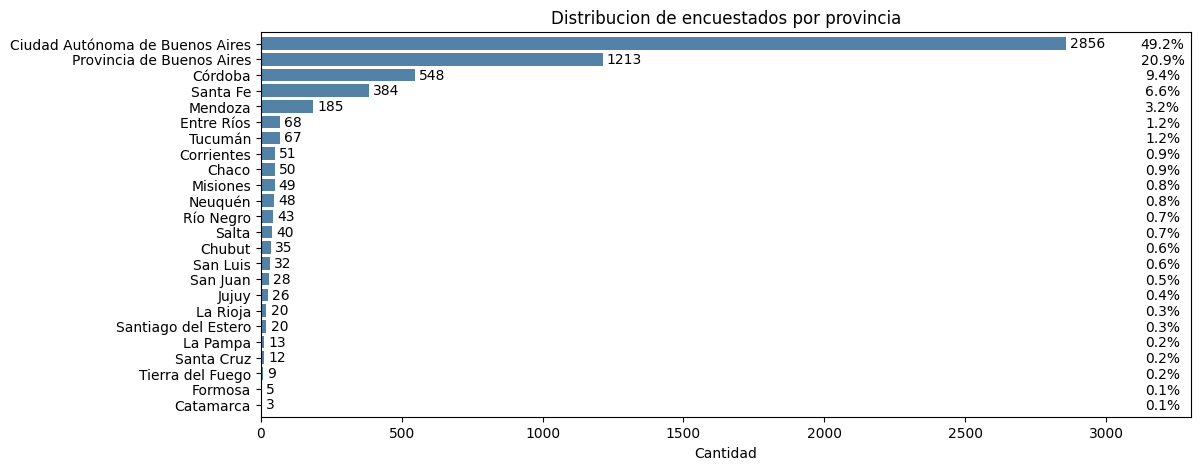

In [50]:
#WORK_PROVINCE
fig = plt.figure(figsize=(12, 5))
ax = sns.countplot(y=salaries['work_province'], color='steelblue', order=df["work_province"].value_counts().index)
plt.title("Distribucion de encuestados por provincia",loc='center')
plt.xlabel("Cantidad")
plt.ylabel('')
#plt.xscale('log')
ax.set_xlim(0,3300)
ax.bar_label(ax.containers[0], padding=3)
ax.margins(y=0.015)

total = len(salaries)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total)
    ax.annotate(percentage, (3200, (p.get_y() + p.get_height() / 2) + 0.5), ha='center', va='bottom', fontsize=10)

18


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

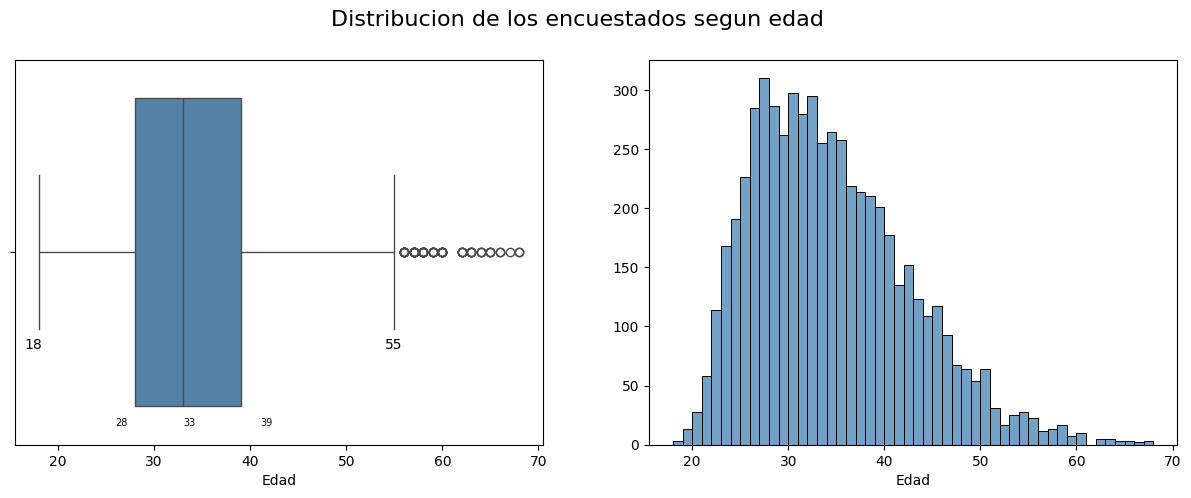

In [51]:
#AGE
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax1 = sns.boxplot(salaries[stats.zscore(salaries['age']) < 3],x ='age', color='steelblue',ax=axes[0])
axes[0].set_xlabel('Edad')
boxplot_plotting_values('age',ax1)

ax2 = sns.histplot(salaries[stats.zscore(salaries['age']) < 3],x ='age', color='steelblue',ax=axes[1],binwidth=1)
axes[1].set_ylabel('')
axes[1].set_xlabel('Edad')
#display(salaries[(salaries['age'] >= 55) & (salaries['age'] <= 70)].shape)

fig.suptitle('Distribucion de los encuestados segun edad', fontsize=16)
plt.tight_layout

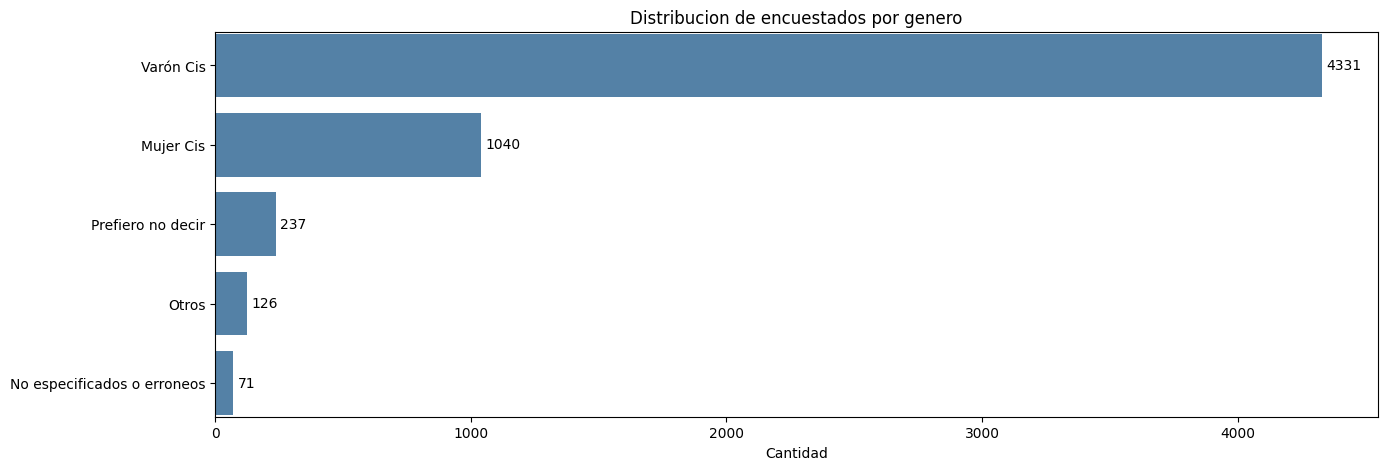

In [52]:
#GENDER
fig = plt.figure(figsize=(15, 5))
ax = sns.countplot(y=salaries['gender'], color='steelblue', order=salaries["gender"].value_counts().index)
plt.title("Distribucion de encuestados por genero",loc='center')
plt.xlabel("Cantidad")
plt.ylabel('')
plt.bar_label(ax.containers[0], padding=3, fontsize = 10)
ax.margins(y=0.005)

**WORK**

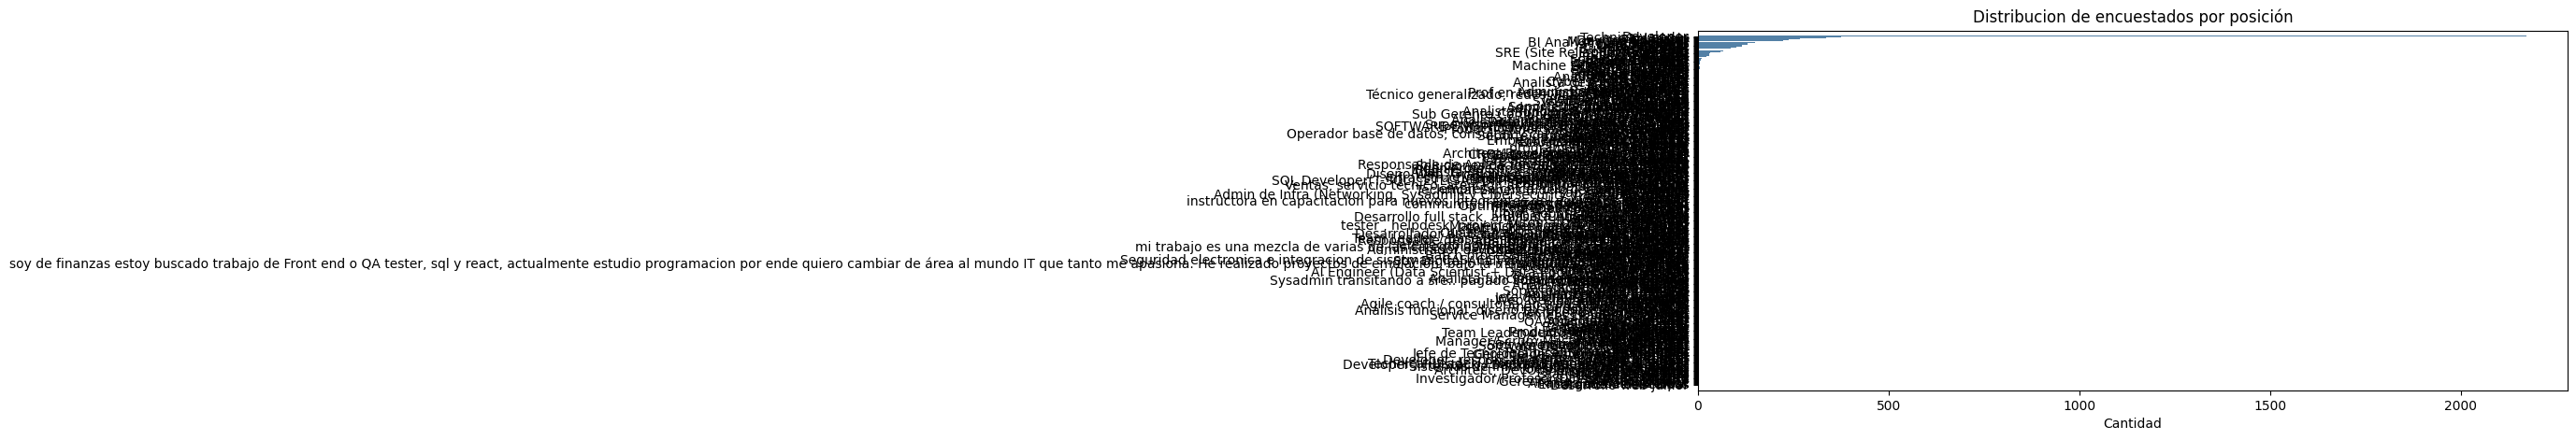

In [ ]:
#WORK_TITLE
fig = plt.figure(figsize=(15, 5))
ax = sns.countplot(y=salaries['work_title'], color='steelblue', order=df["work_title"].value_counts().index)
plt.title("Distribucion de encuestados por posición",loc='center')
plt.xlabel("Cantidad")
plt.ylabel('')
#ax.bar_label(ax.containers[0], padding=3)
ax.margins(y=0.015)

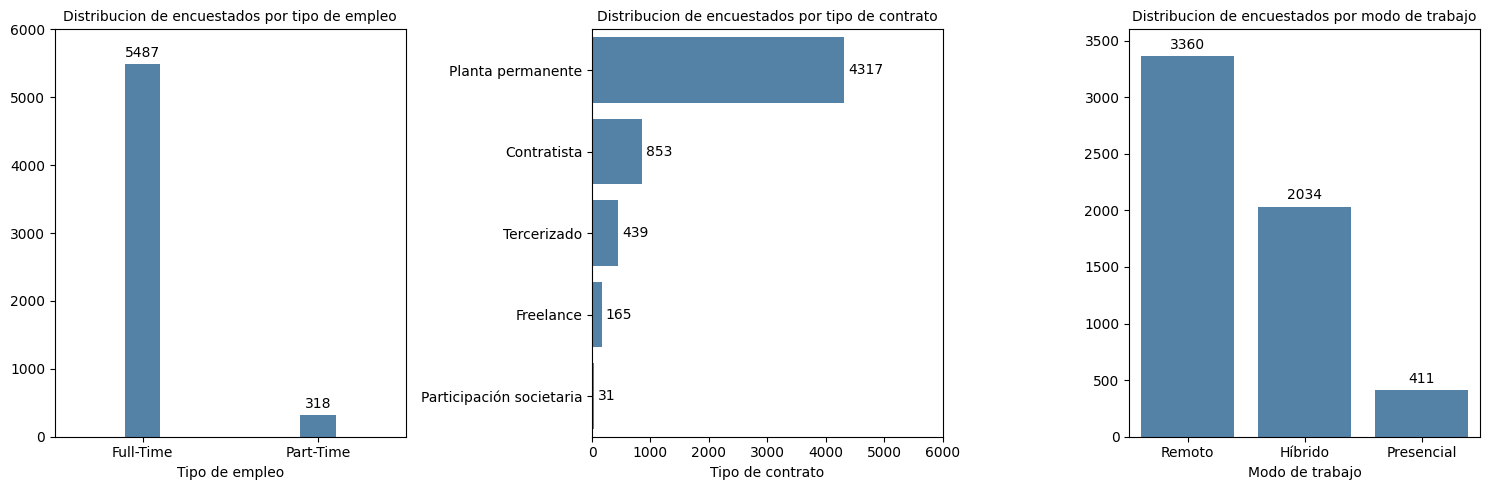

In [55]:
# WORK_DEDICATION, WORK_CONTRACT_TYPE AND WORK_MODE
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
ax1 = sns.countplot(x=salaries['work_type'], color='steelblue',width=0.2,ax=axes[0])
axes[0].set_xlabel("Tipo de empleo")
axes[0].set_ylabel('')
axes[0].set_title("Distribucion de encuestados por tipo de empleo", fontsize=10)
axes[0].set_ylim(0, 6000)
ax1.bar_label(ax1.containers[0], padding=3)

ax2 = sns.countplot(y=salaries['work_contract_type'], color='steelblue',order=salaries["work_contract_type"].value_counts().index,ax=axes[1])
axes[1].set_title("Distribucion de encuestados por tipo de contrato", fontsize=10)
axes[1].set_xlabel("Tipo de contrato")
axes[1].set_ylabel('')
axes[1].set_xlim(0, 6000)
ax2.bar_label(ax2.containers[0], padding=3)


ax3 = sns.countplot(x=salaries['work_mode'], color='steelblue',order=salaries["work_mode"].value_counts().index,ax=axes[2])
axes[2].set_title("Distribucion de encuestados por modo de trabajo", fontsize=10)
axes[2].set_xlabel("Modo de trabajo")
axes[2].set_ylabel('')
axes[2].set_ylim(0, 3600)
ax3.bar_label(ax3.containers[0], padding=3)

plt.tight_layout()

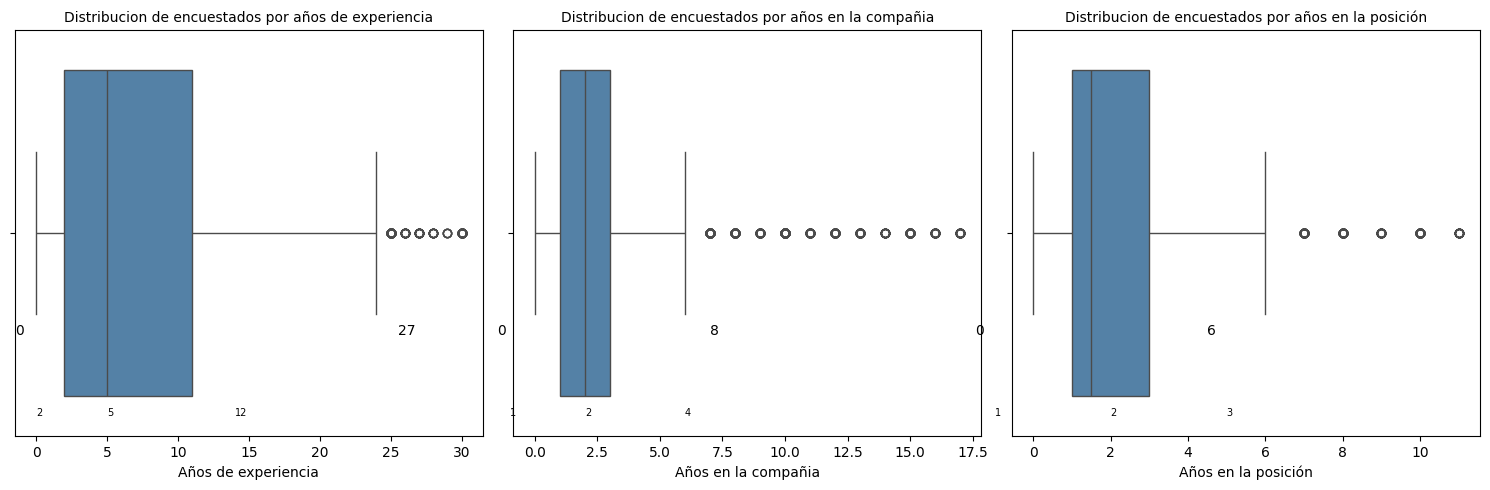

In [59]:
#YEARS_EXPERIENCE, YEARS_IN_COMPANY AND YEARS_IN_POSITION
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

def years (column,subplot,xlabel,title):
    sns.boxplot(salaries[stats.zscore(salaries[column]) < 3],x =column, color='steelblue',ax=subplot)
    subplot.set_xlabel(xlabel)
    subplot.set_label('')
    subplot.set_title(title, fontsize=10)
    plt.tight_layout()

    boxplot_plotting_values(column,subplot)

years('years_experience',axes[0],'Años de experiencia',"Distribucion de encuestados por años de experiencia")
years('years_in_company',axes[1], 'Años en la compañia', "Distribucion de encuestados por años en la compañia")
years('years_in_position',axes[2], 'Años en la posición', "Distribucion de encuestados por años en la posición")

**COMPANY**

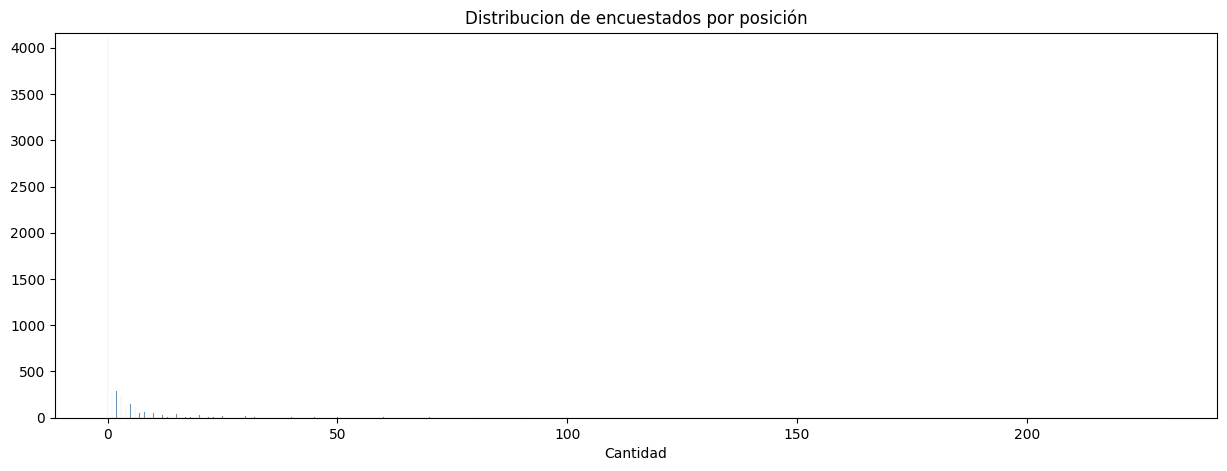

In [76]:
#PEOPLE_IN_CHARGE
fig = plt.figure(figsize=(15, 5))
ax = sns.countplot(salaries['people_in_charge'], color='steelblue')
plt.title("Distribucion de encuestados por posición",loc='center')
plt.xlabel("Cantidad")
plt.ylabel('')
#ax.bar_label(ax.containers[0], padding=3)
ax.margins(y=0.015)

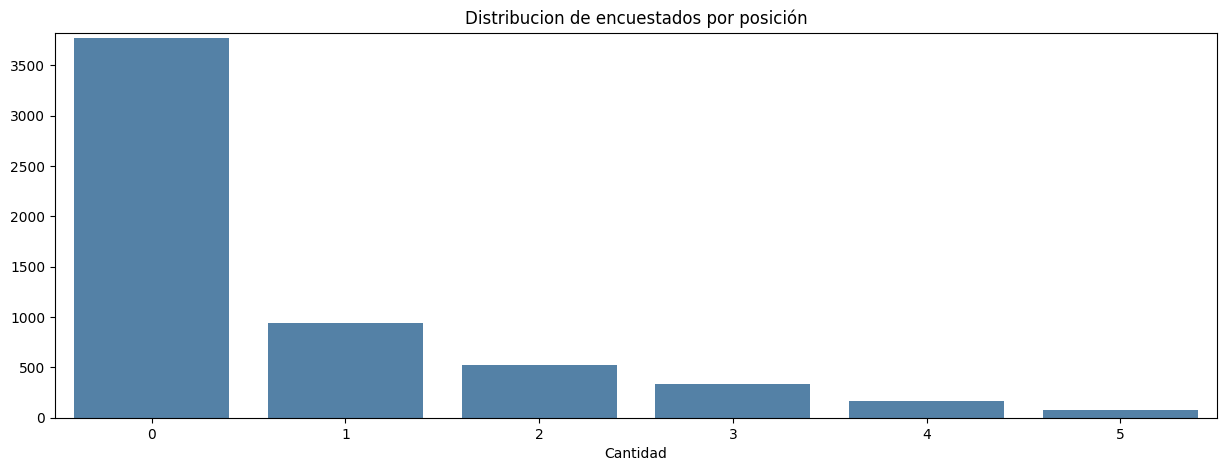

In [78]:
#OFFICE_DAYS_NUMBER(HYBRID)
fig = plt.figure(figsize=(15, 5))
ax = sns.countplot(x = salaries['office_days_number(hybrid)'], color='steelblue')
plt.title("Distribucion de encuestados por posición",loc='center')
plt.xlabel("Cantidad")
plt.ylabel('')
#ax.bar_label(ax.containers[0], padding=3)
ax.margins(y=0.015)

<Axes: xlabel='count', ylabel='work_place_satisfaction'>

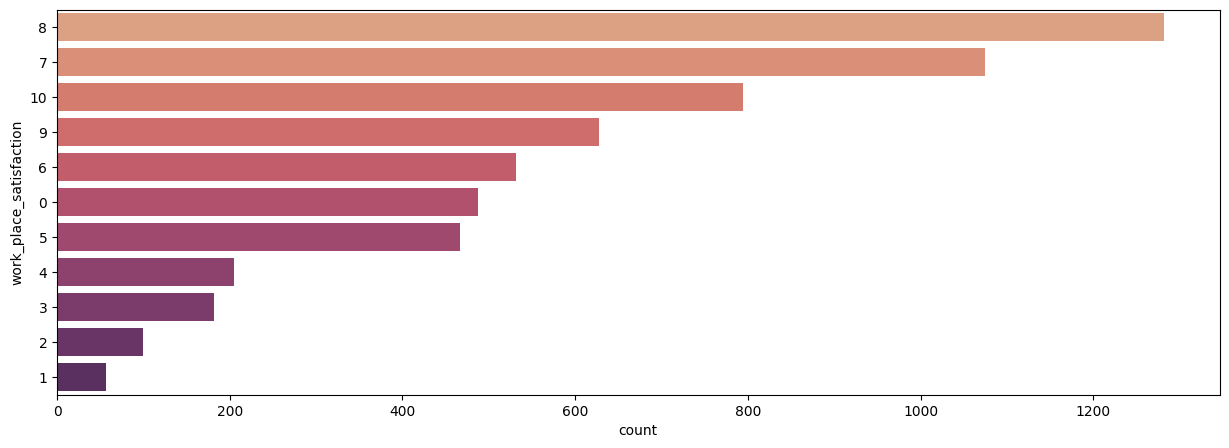

In [64]:
fig = plt.figure(figsize=(15, 5))
sns.countplot(y=salaries['work_place_satisfaction'], palette='flare',order=salaries['work_place_satisfaction'].value_counts().index)

[Text(2, 0, '3018')]

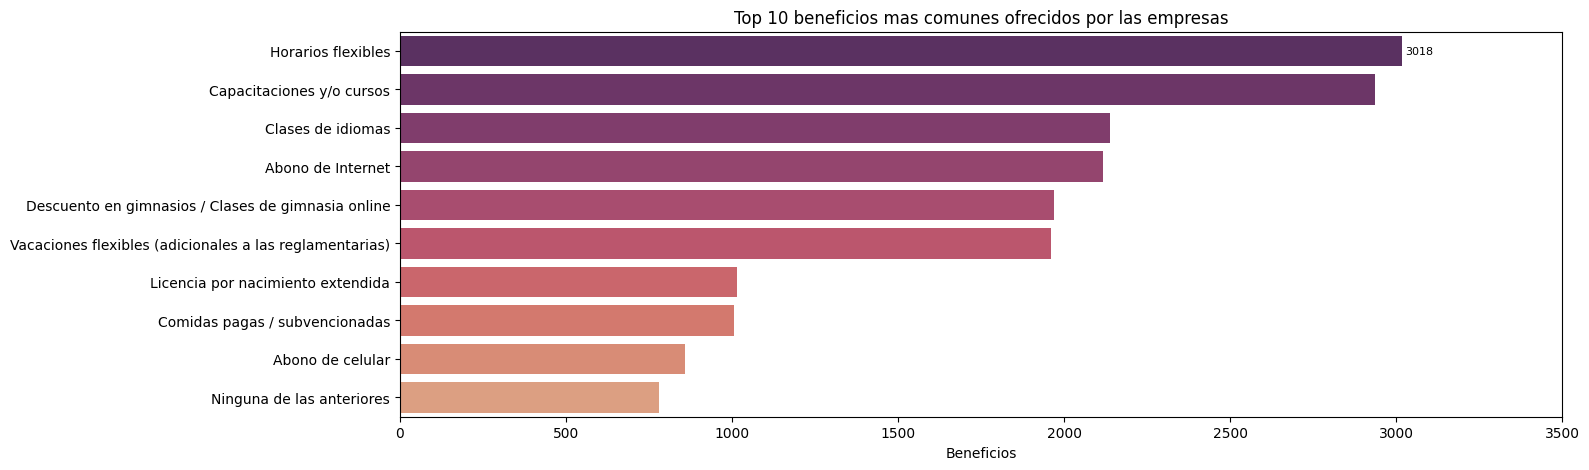

In [69]:
#WORK_PLACE_BENEFITS
fig = plt.figure(figsize=(15, 5))
ax = sns.barplot(data=benefits_count.head(10),y='item',x='counts', palette='flare' + "_r")
plt.title('Top 10 beneficios mas comunes ofrecidos por las empresas',)
plt.xlabel('Beneficios')
plt.ylabel('')
plt.xlim(0,3500)
plt.bar_label(ax.containers[0], padding=2, fontsize=8)

**SALARIES**

In [ ]:
#LAST_MONTH_GROSS_SALARY
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
filtered_gross_salary = salaries[stats.zscore(salaries['last_month_gross_salary']) < 3.5]
ax = sns.histplot(data=filtered_gross_salary,x='last_month_gross_salary', color='steelblue',ax=axes[0],bins=35)
ax.ticklabel_format(style='plain', axis='both')
ax.bar_label(ax.containers[0], padding=3,fontsize=6)
axes[0].set_title("Distribucion de encuestados por percepción de salario bruto", fontsize=16)

#LAST_MONTH_NET_SALARY
filtered_net_salary = salaries[stats.zscore(salaries[~np.isnan(salaries['last_month_net_salary'])])]
print(filtered_net_salary)
ay = sns.histplot(data=filtered_net_salary,x='last_month_net_salary', color='steelblue',ax=axes[1],bins=35)
ay.ticklabel_format(style='plain', axis='both')
axes[1].set_title("Distribucion de encuestados por tipo de empleo", fontsize=16)

plt.tight_layout()

[Text(3, 0, '3865'), Text(3, 0, '379'), Text(3, 0, '773'), Text(3, 0, '788')]

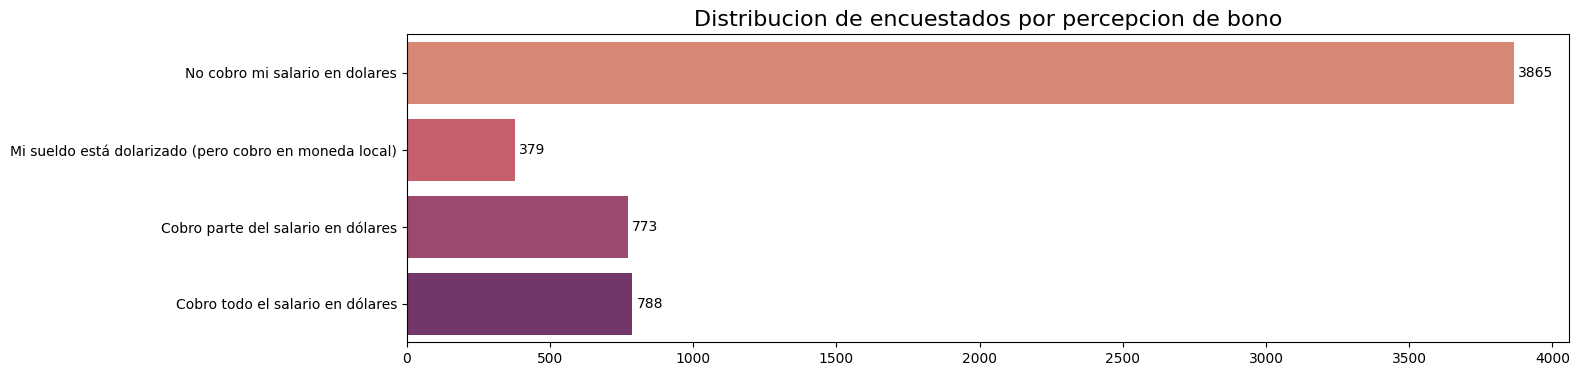

In [ ]:
#SALARY_IN_USD
fig = plt.figure(figsize=(15, 4))
ax = sns.countplot(y=salaries['salary_in_usd'],palette='flare',order=['No cobro mi salario en dolares',
                                                                      'Mi sueldo está dolarizado (pero cobro en moneda local)',
                                                                      'Cobro parte del salario en dólares',
                                                                      'Cobro todo el salario en dólares'
                                                                      ])
plt.xlabel('')
plt.ylabel('')
plt.title('Distribucion de encuestados por percepcion de bono', fontsize=16)
ax.bar_label(ax.containers[0], padding=3)

[Text(3, 0, '3293'),
 Text(3, 0, '759'),
 Text(3, 0, '755'),
 Text(3, 0, '816'),
 Text(3, 0, '182')]

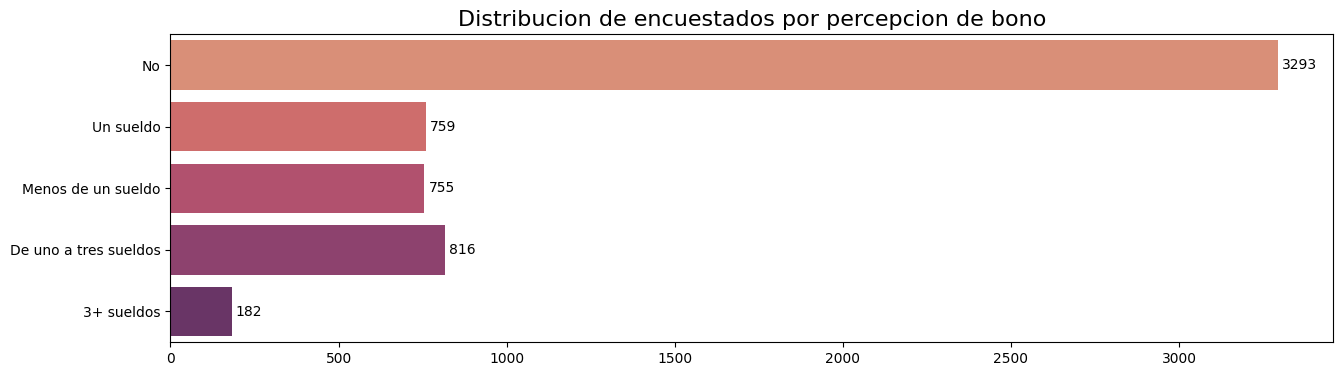

In [ ]:
#SALARY_HAS_BONUS
fig = plt.figure(figsize=(15, 4))
ax = sns.countplot(y=salaries['salary_has_bonus'],palette='flare')
plt.xlabel('')
plt.ylabel('')
plt.title('Distribucion de encuestados por percepcion de bono', fontsize=16)
ax.bar_label(ax.containers[0], padding=3)

In [ ]:
#SALARY_HAS_BONUS (NORMALIZAR)

In [ ]:
#WORK_BENEFITS (NORMALIZAR)

In [1]:
#SALARY_SATISFACTION
print(salaries['salary_satisfaction'].unique())
fig = plt.figure(figsize=(15, 4))
ax = sns.countplot(y=salaries['salary_satisfaction'],palette='flare',order=['Muy insatisfecho','Escasamente satisfecho',
                                                                            'Ampliamente satisfecho','Muy satisfecho'])
plt.xlabel('')
plt.ylabel('')
plt.title('Distribucion de encuestados por satisfaccion salarial', fontsize=16)
ax.bar_label(ax.containers[0], padding=3)

NameError: name 'salaries' is not defined

**TOOLS**

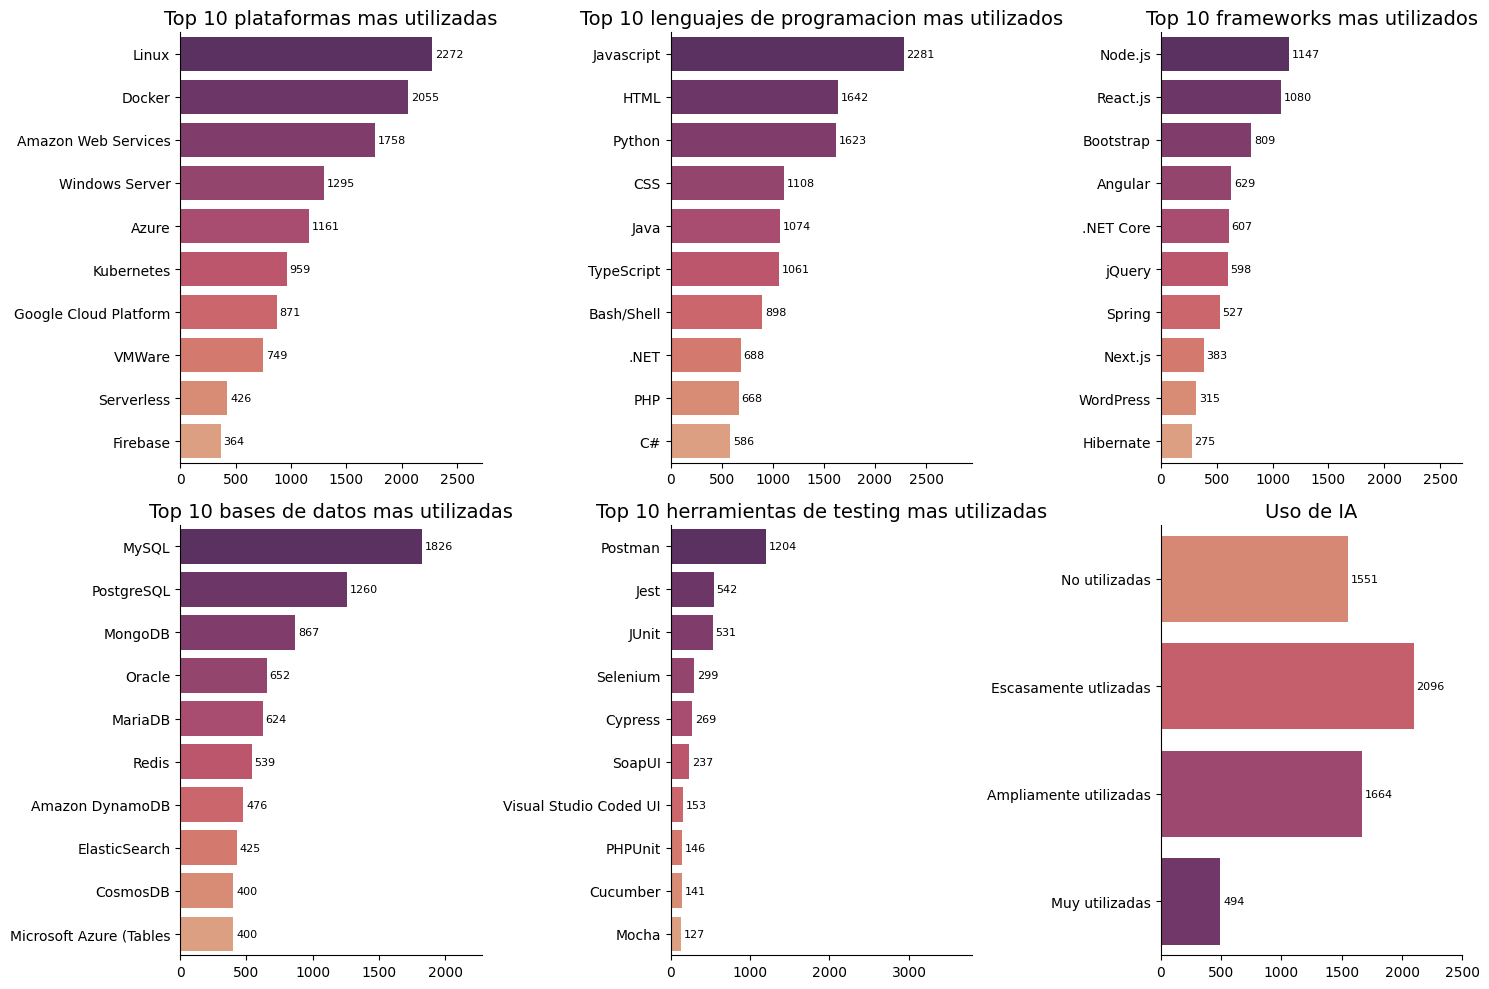

In [215]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
sns.despine(top=True)
def plotting_tools(df,subplot,title):
    ax = sns.barplot(data=df[~df['item'].str.contains(r'Ningun[ao] de l[ao]s anteriores|etc\)|\bSQL\b')].head(10),y='item',x='counts', ax=subplot, palette='flare' + "_r")
    subplot.set_xlabel('')
    subplot.set_ylabel('')
    subplot.set_title('Top 10 ' + title, fontsize=14)
    subplot.set_xlim(0, df.iloc[0,1] + 450)
    ax.bar_label(ax.containers[0], padding=2, fontsize=8)

plotting_tools(platforms_count,axes[0,0],'plataformas mas utilizadas')
plotting_tools(programming_languages_count,axes[0,1],'lenguajes de programacion mas utilizados')
plotting_tools(frameworks_count,axes[0,2],'frameworks mas utilizados')
plotting_tools(databases_count,axes[1,0],'bases de datos mas utilizadas')
plotting_tools(qa_testing_tools_count,axes[1,1],'herramientas de testing mas utilizadas')

ax = sns.countplot(y=salaries['AI_tools_use'], ax=axes[1,2],palette='flare')
axes[1,2].set_xlabel('')
axes[1,2].set_ylabel('')
axes[1,2].set_title('Uso de IA', fontsize=14)
axes[1,2].set_xlim(0, 2500)
ax.bar_label(ax.containers[0], padding=2, fontsize=8)

plt.tight_layout()

**STUDIES**

Text(0, 0.5, '')

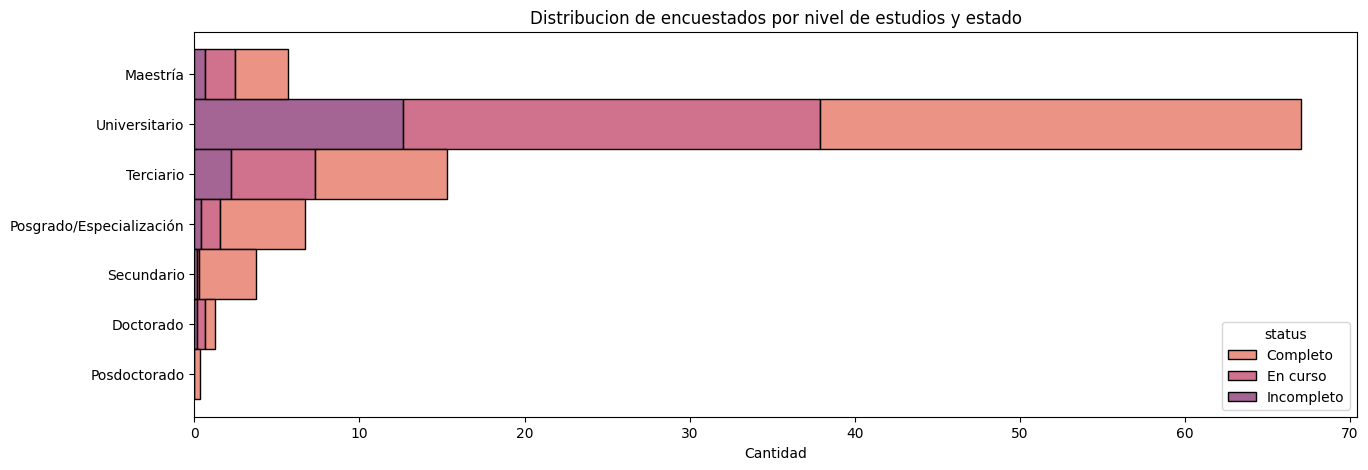

In [27]:
#HIGHEST_LEVEL_STUDIES AND STATUS
fig = plt.figure(figsize=(15, 5))
ax = sns.histplot(salaries[salaries["highest_level_studies"] != 'Prefiero no responder'],y='highest_level_studies', palette='flare',hue='status',multiple='stack',stat='percent')
plt.title("Distribucion de encuestados por nivel de estudios y estado",loc='center')
plt.xlabel("Cantidad")
plt.ylabel('')


Text(150, 8, 'Cantidad de encuestados en esta categoria: 1818')

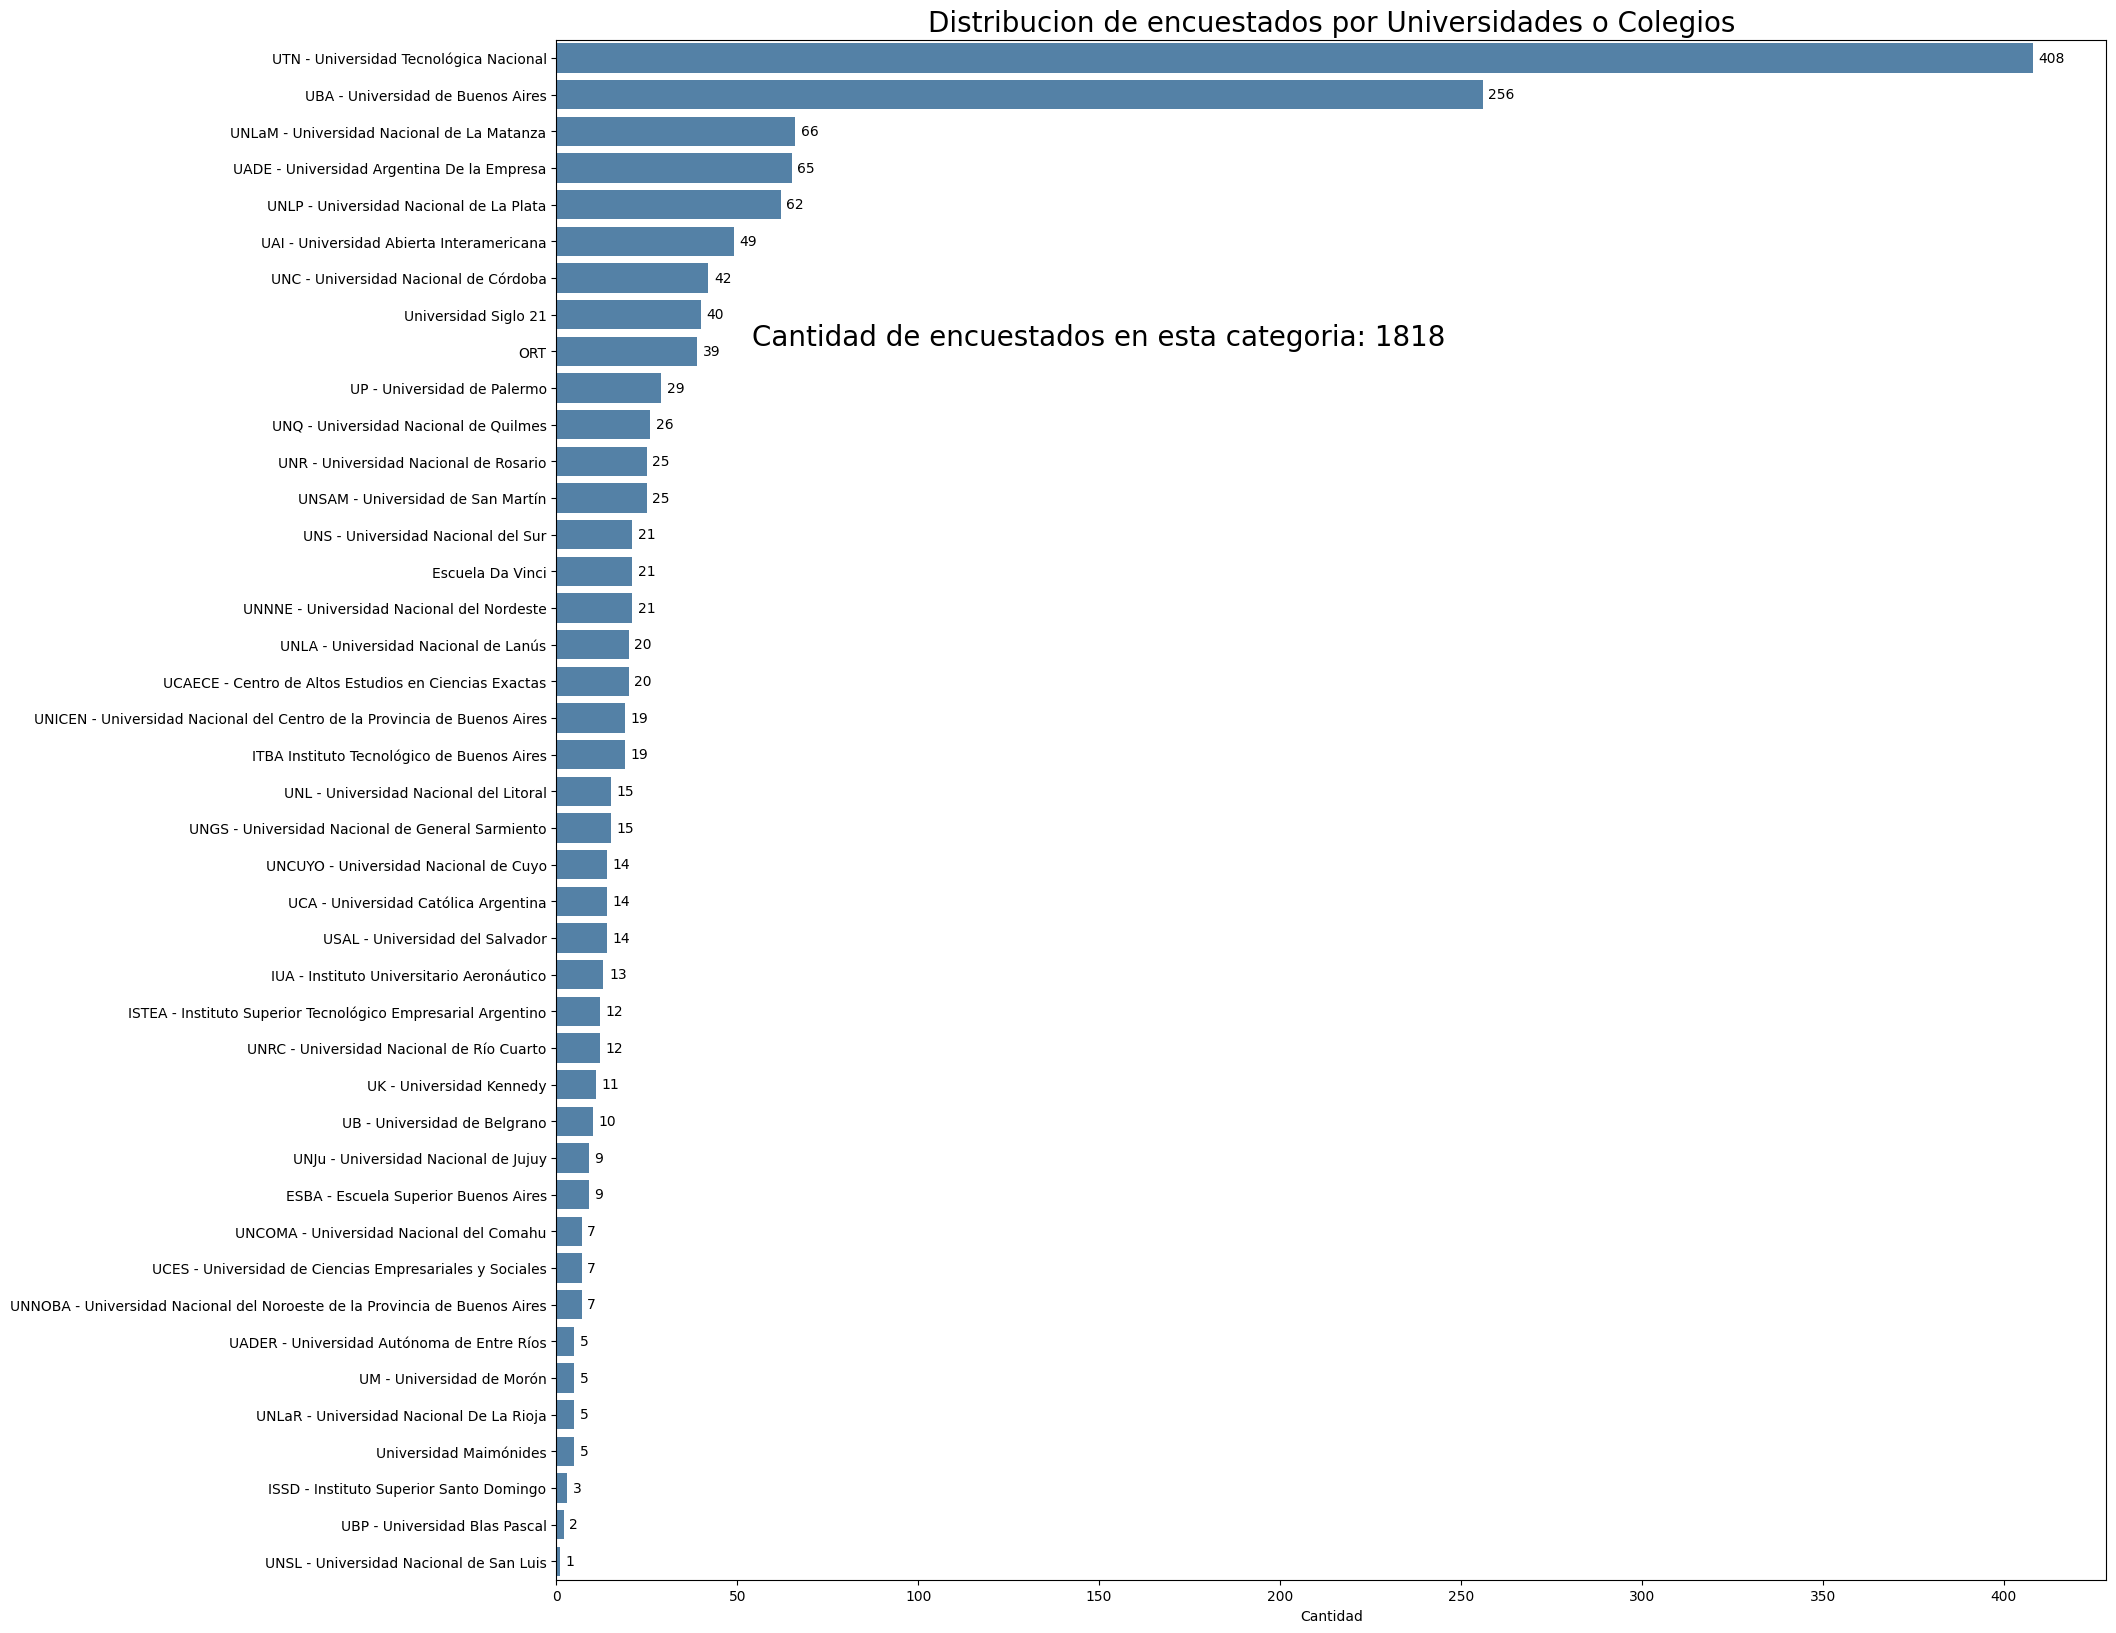

In [ ]:
#UNIVERSITY/SCHOOL
fig = plt.figure(figsize=(20, 20))
ax = sns.countplot(data=salaries[salaries["university/school"] != 'Prefiero no responder'], y="university/school", color='steelblue',
                  order=salaries[salaries["university/school"] != 'Prefiero no responder']["university/school"].value_counts().index)
plt.title("Distribucion de encuestados por Universidades o Colegios", fontsize=20)
plt.xlabel("Cantidad")
plt.ylabel('')
plt.yticks(fontsize=10)
ax.bar_label(ax.containers[0], padding=4)
ax.annotate('Cantidad de encuestados en esta categoria: ' + str((salaries['university/school'] != 'Prefiero no responder').sum()),
             (150, 8), ha='center', va='bottom', fontsize=20)

# EDA: ANALISIS MULTIVARIABLE

**RELACION ENTRE LA EDAD Y LOS AÑOS DE EXPERIENCIA**

Text(0, 0.5, '')

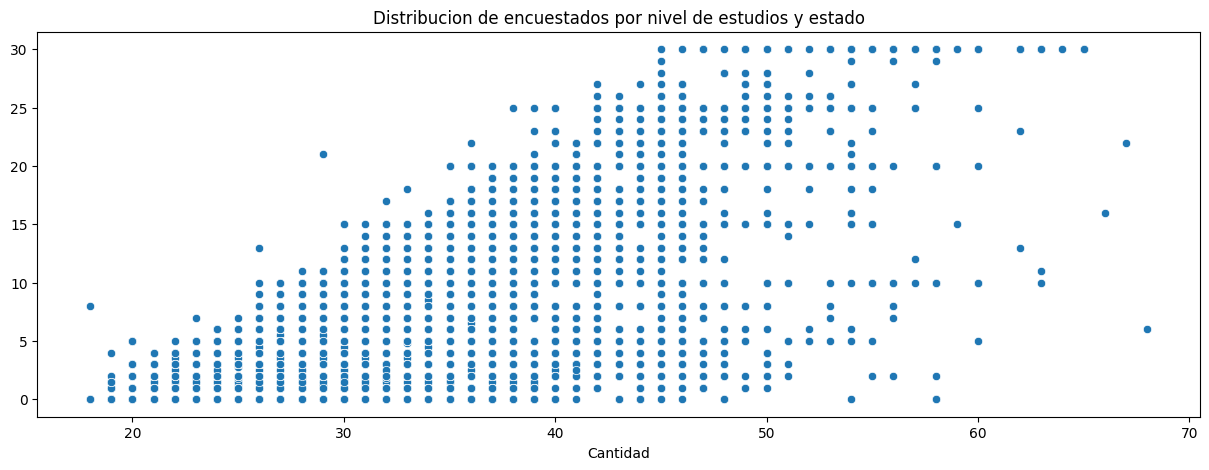

In [29]:
fig = plt.figure(figsize=(15, 5))
ax = sns.scatterplot(x = salaries[stats.zscore(salaries['age']) < 3]['age'], y = salaries[stats.zscore(salaries['years_experience']) < 3]['years_experience'])
plt.title("Distribucion de encuestados por nivel de estudios y estado",loc='center')
plt.xlabel("Cantidad")
plt.ylabel('')